In [2]:
from dotenv import load_dotenv
import os

load_dotenv()

if os.getenv("GROQ_API_KEY"):
    print('Groq API Key loaded successfully')
else:
    print('Groq API Key loading failed, please make sure the .env file exists and the spelling is correct')

if os.getenv("TAVILY_API_KEY"):
    print('Tavily API Key loaded successfully')
else:
    print('Tavily API Key loading failed, please make sure the .env file exists and the spelling is correct')

Groq API Key loaded successfully
Tavily API Key loaded successfully


In [3]:
from langchain_groq import ChatGroq
load_dotenv()

chat_model = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [4]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_groq import ChatGroq
import random
import copy

In [5]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

In [6]:
#TODO: modellierung des games als eigene Klasse außerhalbs des agents inklusive Board, 
#modellierung des akt des Guessens als Custom Tool, welches auch Zugriff auf das Game-Objekt hat, 
#Frage ist nur wie das Tool zugriff darauf bekommt?
# Das Tool soll dann den guess akt + aufdecken processen und das Game updaten.


In [6]:
class Game:

    def __init__(self):
        self.board = self.initialize_board()
        self.red_words = [key for key, value in self.board.items() if value == "red"]
        self.blue_words = [key for key, value in self.board.items() if value == "blue"]
        self.black_words = [key for key, value in self.board.items() if value == "black"]
        self.has_turn = "RED"
        self.winner = None
        self.last_spymaster_answer = None
        self.rounds = 0
        self.guessed_words = set()

    def initialize_board(self):
        word_list = self.load_words()
        board_words = random.sample(word_list, 25)
        colors = ["red"] * 8 + ["blue"] * 8 + ["neutral"] * 7 + ["black"] * 2
        random.shuffle(colors)
        board = dict(zip(board_words, colors))
        return board
    
    def load_words(self):
        with open('wordlist-eng.txt', 'r') as file:
            words = [line.strip() for line in file]
            return words
    
game = Game()

In [ ]:
from typing import Optional, Type

from langchain.callbacks.manager import (
    AsyncCallbackManagerForToolRun,
    CallbackManagerForToolRun,
)
from langchain.pydantic_v1 import BaseModel, Field, PrivateAttr
from langchain.tools import BaseTool, StructuredTool, tool


class GuessInput(BaseModel):
    query: str = Field(description="should be a single word from the game-board")

class CustomGameTool(BaseTool):
    name: str = "custom_game_tool"
    description: str = "essential to guess words from the game-board"
    args_schema: Type[BaseModel] = GuessInput
    game: Game = PrivateAttr()

    def __init__(self, game):
        super().__init__()
        # Store the game object as an instance variable
        self.game = game

    def __call__(self, query: str) -> str:
        """Allows the tool to be callable directly."""
        return self._run(query)

    def _run(
        self, query: str, run_manager: Optional[CallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool with context from the game object."""
        query = query.upper()
        if query in self.game.board.keys() and query not in self.game.guessed_words:
            self.game.guessed_words.add(query)
            return self.game.board[query]
        else:
            return f"WRONG: {query}"

    async def _arun(
        self, query: str, run_manager: Optional[AsyncCallbackManagerForToolRun] = None
    ) -> str:
        """Use the tool asynchronously with context from the game object."""
        raise NotImplementedError("custom_game_tool does not support async")
    
tools = CustomGameTool(game)

/home/jcaspary/anaconda3/envs/LLM/lib/python3.11/site-packages/IPython/core/interactiveshell.py:3577: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
class Agent:
    
    def __init__(self, model, system="", game=None, tools=None):
        # set the system message
        self.game = game
        self.system = system
        self.model = model

        graph = StateGraph(AgentState)

        graph.add_node("spymaster_red", self.call_red_spymaster)
        graph.add_node("spymaster_blue", self.call_blue_spymaster)

        graph.add_node("teammember_red", self.call_red_guesser)
        graph.add_node("teammember_blue", self.call_blue_guesser)

        graph.add_node("action_red", self.take_action)
        graph.add_node("action_blue", self.take_action)

        graph.add_conditional_edges(
             "action_blue",
             self.check_game_end,
             {True: END, False: "spymaster_red"}
        )
        graph.add_conditional_edges(
             "action_red",
             self.check_game_end,
             {True: END, False: "spymaster_blue"}
        )
        # add edge back from action to the LLM
        graph.add_edge("spymaster_red", "teammember_red")
        graph.add_edge("teammember_red", "action_red")
        #graph.add_edge("guess_word_red", "spymaster_blue")
        graph.add_edge("spymaster_blue", "teammember_blue")
        graph.add_edge("teammember_blue", "action_blue")
        #graph.add_edge("guess_word_blue", "spymaster_red")
        # set the starting point of the graph
        graph.set_entry_point("spymaster_red")
        # create the graph and turn it into a LangChain Runnable (allows to call methods like .invoke,...)
        self.graph = graph.compile()
        # create the available tools as dictionary
        self.tools = {t.name: t for t in tools}
        # make them available to the model
        self.model = model.bind_tools(tools)

    # the condition for the conditional edge
    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    # method for the llm node
    def call_groq(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        return {'messages': [message]}
    
    def guess_word(self, word: str, team: str):
        if word not in self.game.board.keys() or word in self.game.guessed_words:
            return "INVALID_GUESS"
        else:
            #self.game.guessed_words.add(word)
            #card = self.game.board[word]
            #if card == team:
            #    return "CORRECT_MOVE"
            #else:
            #    return f"WRONG_GUESS: {card}"
            return "CORRECT GUESS"

    # def guess_word_red(self, word: str):
    #     return self.guess_word(word, "RED")
    
    # def guess_word_blue(self, word: str):
    #     return self.guess_word(word, "BLUE")

    def call_red_spymaster(self, state: AgentState):
        self.game.rounds = self.game.rounds + 1
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(self.get_spymaster_prompt("RED"))
        self.game.last_spymaster_answer = message
        return {'messages': [message]}
    
    def call_blue_spymaster(self, state: AgentState):
        self.game.rounds = self.game.rounds + 1
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(self.get_spymaster_prompt("BLUE"))
        self.game.last_spymaster_answer = message
        return {'messages': [message]}
    
    def call_red_guesser(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(self.get_guesser_prompt("RED"))
        self.game.last_spymaster_answer = message
        return {'messages': [message]}
    
    def call_blue_guesser(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(self.get_guesser_prompt("BLUE"))
        self.game.last_spymaster_answer = message
        return {'messages': [message]}
            

            
    # def passing(self):
    #     return "PASS"
    
    def check_game_end(self, state: AgentState):
        game_over = False
        if self.game.rounds > 5:
            game_over = True
        game_ends_black = any(word in self.game.guessed_words for word in self.game.black_words)
        game_ends_red = all(word in self.game.guessed_words for word in self.game.red_words)
        game_ends_blue = all(word in self.game.guessed_words for word in self.game.blue_words)
        if game_ends_black or game_ends_red or game_ends_blue:
            game_over = True
        if game_ends_black:
            if self.game.has_turn == "RED":
                self.game.winner = "BLUE"
            else:
                self.game.winner = "RED"
        elif game_ends_red:
            self.game.winner = "RED"
        elif game_ends_blue:
            self.game.winner = "BLUE"
        if game_over:
            print(f"guessed_words: {', '.join(self.game.guessed_words)}")
            print(f"WINNER: {self.game.winner}")
            print(f"ROUNDS PLAYED: {self.game.rounds}")
            return True
        else:
            return False
            
    def get_spymaster_prompt(self, team):
        not_guessed_board = {key: value for key, value in copy.deepcopy(self.game.board).items() if key not in self.game.guessed_words}
        if team == "RED":
            relevant_words = [key for key, value in not_guessed_board.items() if value == "red"]
            bad_words = [key for key, value in not_guessed_board.items() if value != "red"]
        else:
            relevant_words = [key for key, value in not_guessed_board.items() if value == "blue"]
            bad_words = [key for key, value in not_guessed_board.items() if value != "blue"]
        
        prompt = (
            self.get_spymaster_prompt_raw() + "\n"
            f"Good words: {', '.join(relevant_words)}\n"
            f"Bad words: {', '.join(bad_words)}"
        )
        return prompt
        
    def get_guesser_prompt(self, team):
        not_guessed_board = {key: value for key, value in copy.deepcopy(self.game.board).items() if key not in self.game.guessed_words}.keys()
        prompt = (
            self.get_guesser_prompt_raw(team) + "\n"
            f"Word list: {', '.join(not_guessed_board)}\n"
            f"Hint word: {self.game.last_spymaster_answer}"
        )
        return prompt


    # method for the action node
    def take_action(self, state: AgentState):
        guess_limit = 1
        guesses = 0
        tool_calls = state['messages'][-1].tool_calls
        print(self.tools)
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
                guesses = guesses + 1
            results.append(ToolMessage(tool_call_id=t['id'], name=t['name'], content=str(result)))
            if guesses >= guess_limit:
                break
        print("Back to the model!")

        # the returned messages are automatically added to the existing agent stae each time
        return {'messages': results}
    
    def get_spymaster_prompt_raw(self):
        return """You must only answer with one word. \
You are given two list of words, good words and bad words \
With your answer, describe the good words as best as possible while not describing the bad words \
I do not know which words are good or bad and have to guess based on your answer, which words are good. \n\n
"""

    def get_guesser_prompt_raw(self, team):
        if team == "RED":
            team_name = "red"
        else:
            team_name = "blue"
        return f"""Given the list of Word list and the hint word, use the guessing tool to guess which word is best described by the hint word. \n\n
"""
    

In [10]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatGroq(
    model="llama-3.1-70b-versatile",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

# pass the LLM, the tool (only one here) and the system prompt
abot = Agent(model, system=prompt, game=game, tools=[tools])

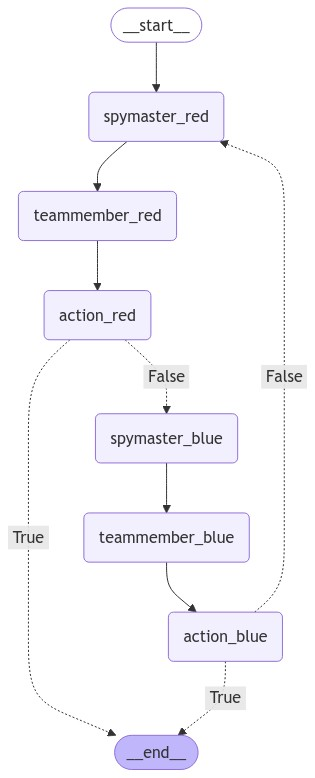

In [11]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(
    Image(
        abot.graph.get_graph().draw_mermaid_png(
            draw_method=MermaidDrawMethod.API,
        )
    )
)

In [12]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

{'custom_game_tool': CustomGameTool(game=<__main__.Game object at 0x7f916da4a610>)}
Calling: {'name': 'custom_game_tool', 'args': {'query': 'ALPS'}, 'id': 'call_16kh', 'type': 'tool_call'}
Back to the model!
{'custom_game_tool': CustomGameTool(game=<__main__.Game object at 0x7f916da4a610>)}
Calling: {'name': 'custom_game_tool', 'args': {'query': 'MAGICAL'}, 'id': 'call_8kg5', 'type': 'tool_call'}
Back to the model!
{'custom_game_tool': CustomGameTool(game=<__main__.Game object at 0x7f916da4a610>)}
Calling: {'name': 'custom_game_tool', 'args': {'query': 'OCTOPUS'}, 'id': 'call_ac7g', 'type': 'tool_call'}
Back to the model!
{'custom_game_tool': CustomGameTool(game=<__main__.Game object at 0x7f916da4a610>)}
Calling: {'name': 'custom_game_tool', 'args': {'query': 'ANGEL'}, 'id': 'call_eafz', 'type': 'tool_call'}
Back to the model!
{'custom_game_tool': CustomGameTool(game=<__main__.Game object at 0x7f916da4a610>)}
Calling: {'name': 'custom_game_tool', 'args': {'query': 'VAN'}, 'id': 'call_d

In [13]:
result

{'messages': [HumanMessage(content='What is the weather in sf?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_4wb0', 'function': {'arguments': '{"query": "single word that is a noun and can be found in a mountainous region"}', 'name': 'custom_game_tool'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 30, 'prompt_tokens': 371, 'total_tokens': 401, 'completion_time': 0.12, 'prompt_time': 0.165926733, 'queue_time': 2.598705853, 'total_time': 0.285926733}, 'model_name': 'llama-3.1-70b-versatile', 'system_fingerprint': 'fp_5c5d1b5cfb', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-fdfcc5a2-345c-4ec2-a2a3-3d7b97d3474d-0', tool_calls=[{'name': 'custom_game_tool', 'args': {'query': 'single word that is a noun and can be found in a mountainous region'}, 'id': 'call_4wb0', 'type': 'tool_call'}], usage_metadata={'input_tokens': 371, 'output_tokens': 30, 'total_tokens': 401}),
  AIMe